In [1]:
import sys
sys.path.append("../../")
sys.path.append("../donnees")
import skfmm
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

In [3]:
import scipy.io
#mat = scipy.io.loadmat('Neutral_Fiber_SPPI-0200_compacte/Coord_Fibres_Neutres.mat')
Image = io.imread('noncompacted.tif')
print(Image.shape)

(1798, 447, 1940)


In [4]:
gt=[]
I=[]
for i in range (50,1780): #sens1
    gt.append(io.imread("lab/warp/slice"+str(i)+"lab.png"))#sélection des masks
    I.append(Image[i,:,:])
gt=np.abs(np.asarray(gt))
I=np.abs(np.asarray(I))
print(gt.shape)
print(I.shape)

(1730, 447, 1940)
(1730, 447, 1940)


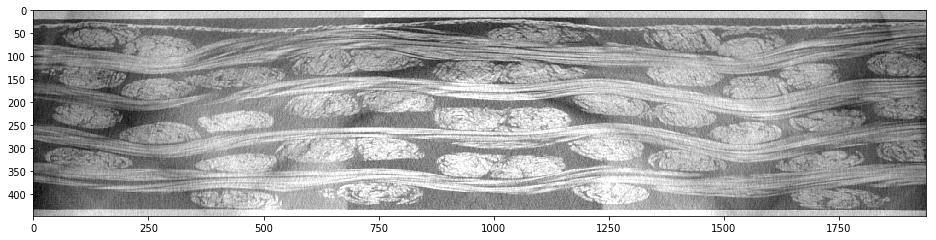

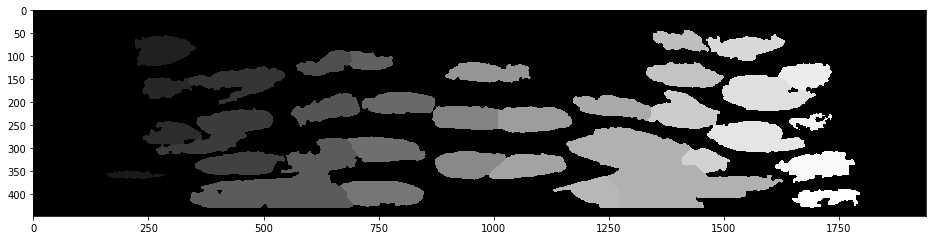

In [6]:
klayer=0#np.random.randint(0,gt.shape[0])
plt.figure(figsize=(16,16))
plt.imshow(I[klayer,:,:],cmap='gray')
plt.figure(figsize=(16,16))
mask=gt[klayer,:,:]#==np.random.randint(0,40)
plt.imshow(mask,cmap='gray')

In [7]:
import os
import re
import datetime
import numpy as np
from itertools import groupby
from skimage import measure
from PIL import Image
from pycocotools import mask

convert = lambda text: int(text) if text.isdigit() else text.lower()
natrual_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]

def resize_binary_mask(array, new_size):
    image = Image.fromarray(array.astype(np.uint8)*255)
    image = image.resize(new_size)
    return np.asarray(image).astype(np.bool_)

def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
                counts.append(0)
        counts.append(len(list(elements)))

    return rle

def binary_mask_to_polygon(binary_mask, tolerance=0):
    """Converts a binary mask to COCO polygon representation
    Args:
        binary_mask: a 2D binary numpy array where '1's represent the object
        tolerance: Maximum distance from original points of polygon to approximated
            polygonal chain. If tolerance is 0, the original coordinate array is returned.
    """
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation 
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)

    return polygons

def create_image_info(image_id, file_name, image_size, 
                      date_captured=datetime.datetime.utcnow().isoformat(' '),
                      license_id=1, coco_url="", flickr_url=""):
    print("width:",image_size[1],"height:", image_size[0])
    image_info = {
            "id": image_id,
            "file_name": file_name,
            "width": image_size[0],
            "height": image_size[1],
            "date_captured": date_captured,
            "license": license_id,
            "coco_url": coco_url,
            "flickr_url": flickr_url
    }

    return image_info

def create_annotation_info(annotation_id, image_id, category_info, binary_mask, 
                           image_size=None, tolerance=2, bounding_box=None):

    if image_size is not None:
        binary_mask = resize_binary_mask(binary_mask, image_size)

    binary_mask_encoded = mask.encode(np.asfortranarray(binary_mask.astype(np.uint8)))

    area = mask.area(binary_mask_encoded)
    if area < 1:
        return None

    if bounding_box is None:
        bounding_box = mask.toBbox(binary_mask_encoded)

    if category_info["is_crowd"]:
        is_crowd = 1
        segmentation = binary_mask_to_rle(binary_mask)
    else :
        is_crowd = 0
        segmentation = binary_mask_to_polygon(binary_mask, tolerance)
        if not segmentation:
            return None
    print("width:",binary_mask[1],"height:", binary_mask[0])
    annotation_info = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_info["id"],
        "iscrowd": is_crowd,
        "area": area.tolist(),
        "bbox": bounding_box.tolist(),
        "segmentation": segmentation,
        "width": binary_mask.shape[1],
        "height": binary_mask.shape[0],
    } 

    return annotation_info

In [8]:
INFO = {
    "description": "Weaving",
    "url": "None",
    "version": "0.1.0",
    "year": 2019,
    "contributor": "SAFRAN",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "Unknown",
        "url": "Unknown"
    }
]

CATEGORIES = [
    {
        'id': 1,
        'name': 'strand',
        'supercategory': 'shape',
    },

]

count = 39


Text(0.5,1,'mask')

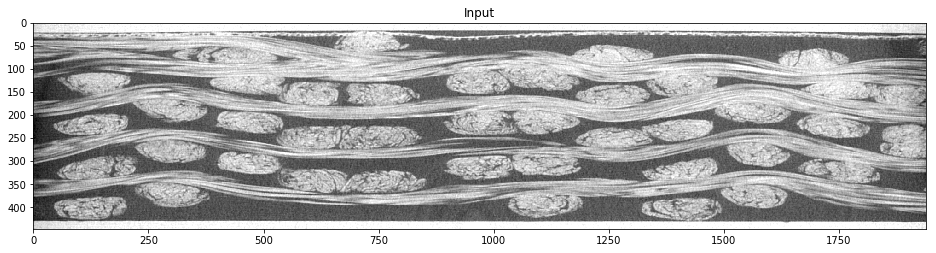

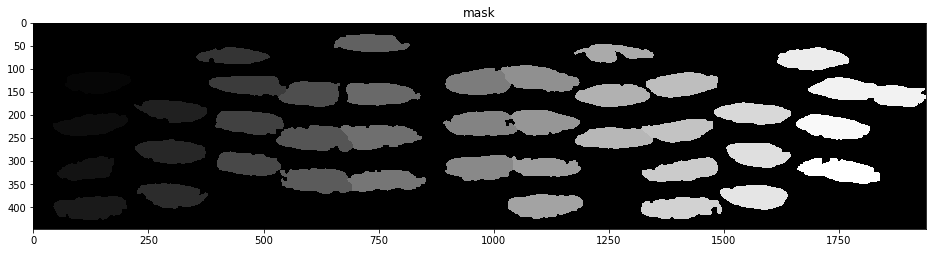

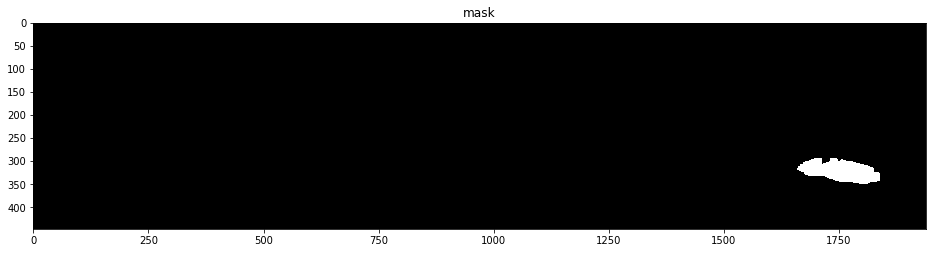

In [9]:
klayer=np.random.randint(0,int(gt.shape[0]*(2/3)))
xini=np.random.randint(gt.shape[1]-256)
yini=np.random.randint(gt.shape[2]-256)
coord=(xini,yini,klayer)
label=np.unique(gt[klayer,:,:])
mask=(gt[klayer,:,:])
image=I[klayer,:,:]
count=0
for i in label[1:]:
    count=count+1
print('count =',count)
binary=np.asarray((mask==i)).astype(np.uint8)
plt.figure(figsize=(16,16))
plt.imshow(image,cmap='gray')
plt.title("Input")
plt.figure(figsize=(16,16))
plt.imshow(mask,cmap='gray')
plt.title("mask")
plt.figure(figsize=(16,16))
plt.imshow(binary,cmap='gray')
plt.title("mask")

In [10]:
import datetime
import json
from pycococreatortools import pycococreatortools
ROOT_DIR = 'train'
class_id = 1
segmentation_id =  1
nb_train_samples=int(1730*(2/3))
nb_val_samples=int(1730*(1/3))
coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],
    "annotations": []
}
print('trainset')
for image_id in range (0,int(nb_train_samples)):
    klayer=image_id
    image=I[klayer,:,:]
    im = Image.fromarray(image)
    image_filename="train/shapes_train2018/"+str(image_id)+"strand.jpeg"
    im.save(image_filename)
    image_info = pycococreatortools.create_image_info(
        image_id,image_filename, image.shape)
    coco_output["images"].append(image_info)
    label=np.unique(gt[klayer,:,:])
    mask=(gt[klayer,:,:])
    # go through each associated annotation
    for i in label[1:]:
        category_info = {'id': class_id, 'is_crowd':0}
        binary_mask = np.asarray((mask==i)).astype(np.uint8)
        if(i==0):
            print("id=",segmentation_id)
        annotation_info = pycococreatortools.create_annotation_info(
            segmentation_id, image_id, category_info, binary_mask, tolerance=2)
        if annotation_info is not None:
            coco_output["annotations"].append(annotation_info)
        im = Image.fromarray(binary_mask*255)
        image_filename="train/annotations/"+str(image_id)+"_strand_"+str(segmentation_id)+".png"
        im.save(image_filename)
        segmentation_id = segmentation_id + 1
            
    with open('{}/instances_shape_train2018.json'.format(ROOT_DIR), 'w') as output_json_file:
        json.dump(coco_output, output_json_file)
print('valset')
for k in range (0,int(nb_val_samples)):
    image_id=image_id+1
    klayer=image_id
    image=I[klayer,:,:]
    im = Image.fromarray(image)
    image_filename="train/shapes_train2018/"+str(image_id)+"strand.jpeg"
    im.save(image_filename)
    image_info = pycococreatortools.create_image_info(
        image_id,image_filename, image.shape)
    coco_output["images"].append(image_info)
    label=np.unique(gt[klayer,:,:])
    mask=(gt[klayer,:,:])
    # go through each associated annotation

    for i in label[1:]:
            category_info = {'id': class_id, 'is_crowd':0}
            binary_mask = np.asarray((mask==i)).astype(np.uint8)
            annotation_info = pycococreatortools.create_annotation_info(
                segmentation_id, image_id, category_info, binary_mask, tolerance=2)
            if annotation_info is not None:
                coco_output["annotations"].append(annotation_info)
            im = Image.fromarray(binary_mask*255)
            image_filename="train/annotations/"+str(image_id)+"_strand_"+str(segmentation_id)+".png"
            im.save(image_filename)
            segmentation_id = segmentation_id + 1
            
    with open('{}/instances_shape_val2018.json'.format(ROOT_DIR), 'w') as output_json_file:
        json.dump(coco_output, output_json_file)

trainset
valset


In [ ]:
#https://patrickwasp.com/create-your-own-coco-style-dataset/